# Neural network development for turbulence modeling in URANS simulations of non-Newtonian media slope flows

URANS mathematical model:
\begin{equation}
	\label{vof}
	\left\{
		\begin{aligned}
			&\boldsymbol{\nabla} \cdot \bar{\boldsymbol{u}} = 0,\\
			&\frac{\partial \bar{\alpha}}{\partial t} + \boldsymbol{\nabla} \cdot (\bar{\boldsymbol{u}} \bar{\alpha}) = 0,\\
			&\frac{\partial (\rho \bar{\boldsymbol{u}})}{\partial t} + \boldsymbol{\nabla} \cdot (\rho \bar{\boldsymbol{u}} \bar{\boldsymbol{u}}) = -\boldsymbol{\nabla} \bar{p} + \boldsymbol{\nabla} \cdot \bar{\boldsymbol{\tau}} + \rho \bar{\boldsymbol{f}}.
		\end{aligned}
	\right.
\end{equation}
Here $\bar{\boldsymbol{u}}$ is the speed of the mixture, horizontal bar means Reynolds averaging, $\bar{\alpha}$ is the volume fraction of the selected phase, $\bar{\boldsymbol{\tau}} = \bar{\boldsymbol{\tau}}_{Re} + \bar{\boldsymbol{\tau}}_m$ is the stress tensor calculated as sum of Reynolds stress tensor and viscous stress tensor, $\bar{\boldsymbol{\tau}}_m = 2 \mu \bar{\boldsymbol{s}}$ is the viscous stress tensor, which is a function of the strain rate tensor $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$, $\mu = \nu \rho$ is dynamic viscosityof a mixture which is calculated as a product of density and kinematic viscosity of mixture, $\nu = \nu_1 \bar{\alpha} + \nu_0 (1 -\bar{\alpha})$ is the kinemsatic viscosity of mixture calculated according to the principle of the weighted average, $\nu_0$ is a constant, $\nu_1 = min (\nu_*, (\tau_* + K \dot{\gamma}^n) / \dot{\gamma})$ is Herschel-Bulkley reology ratio, $\rho = \rho_1 \bar{\alpha} + \rho_0 (1 - \bar{\alpha})$ is the mixture density, $\rho_0$ and $\rho_1$ are constants, $\bar{p}$ is the pressure, $\bar{\boldsymbol{f}}$ is the density of the body forces.

The $\bar{\boldsymbol{\tau}}_{Re}$ Reynolds stress tensor is calculetaed using Tensor Basis Neural Network (TBNN) according to the principle presented in the work of Pope [1]. It is presented as function of strain rate $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ and rotation rate $\bar{\boldsymbol{r}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} - (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ tensors, and 10 their isotropic combinations $T^i$ and 5 invariants $\lambda_i$. Calculations performed for normalized tensors $\bar{\tau}_{Re}'$, $\bar{\boldsymbol{s}}'$, $\bar{\boldsymbol{r}}'$. The scaling parameters $U_0$, $h_0$, $\rho$ used for normalization:

\begin{equation}
	\label{norm}
	\left\{
		\begin{aligned}
			&\bar{\boldsymbol{\tau}}_{Re} = \bar{\boldsymbol{\tau}}_{Re}' \rho U_0 h_0,\\
			&\bar{\boldsymbol{s}} = \bar{\boldsymbol{s}}' U_0^2 / h_0,\\
			&\bar{\boldsymbol{r}} = \bar{\boldsymbol{r}}' U_0^2 / h_0.
		\end{aligned}
	\right.
\end{equation}

In what follows, we omit the apostrophe symbol and keep in mind that we are considering normalized tensors.

Normalized Reynolds stress tensor is

\begin{equation}
	\label{MLReynolds}
	\bar{\boldsymbol{\tau}}_{Re} = \sum\limits_{n=1}^{10} g^{(n)} (\lambda_1, ... , \lambda_5) \boldsymbol{T}^{(n)}.
\end{equation}

\begin{equation}
	\begin{aligned}
		&\boldsymbol{T}^{(1)} = \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(6)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} + \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \frac{2}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(2)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} - \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(7)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} \bar{\boldsymbol{r}},\\
		&\boldsymbol{T}^{(3)} = \bar{\boldsymbol{s}}^2 - \frac{1}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2),
		&&\boldsymbol{T}^{(8)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},\\
		&\boldsymbol{T}^{(4)} = \bar{\boldsymbol{r}}^2 - \frac{1}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{r}}^2),
		&&\boldsymbol{T}^{(9)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 + \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \frac{2}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(5)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
		&&\boldsymbol{T}^{(10)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
	\end{aligned}
\end{equation}
\begin{equation}
	\lambda_1 = Tr(\bar{\boldsymbol{s}}^2),\ \ \ \ \lambda_2 = Tr(\bar{\boldsymbol{r}}^2),\ \ \ \ \lambda_3 = Tr(\bar{\boldsymbol{s}}^3),\ \ \ \ \lambda_4 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}),\ \ \ \ \lambda_5 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2).
\end{equation}

Calculations performed for turbulent flow in inclined chute with the rectangular cross-section. Scheme of flow is shown in figure below.

<div>
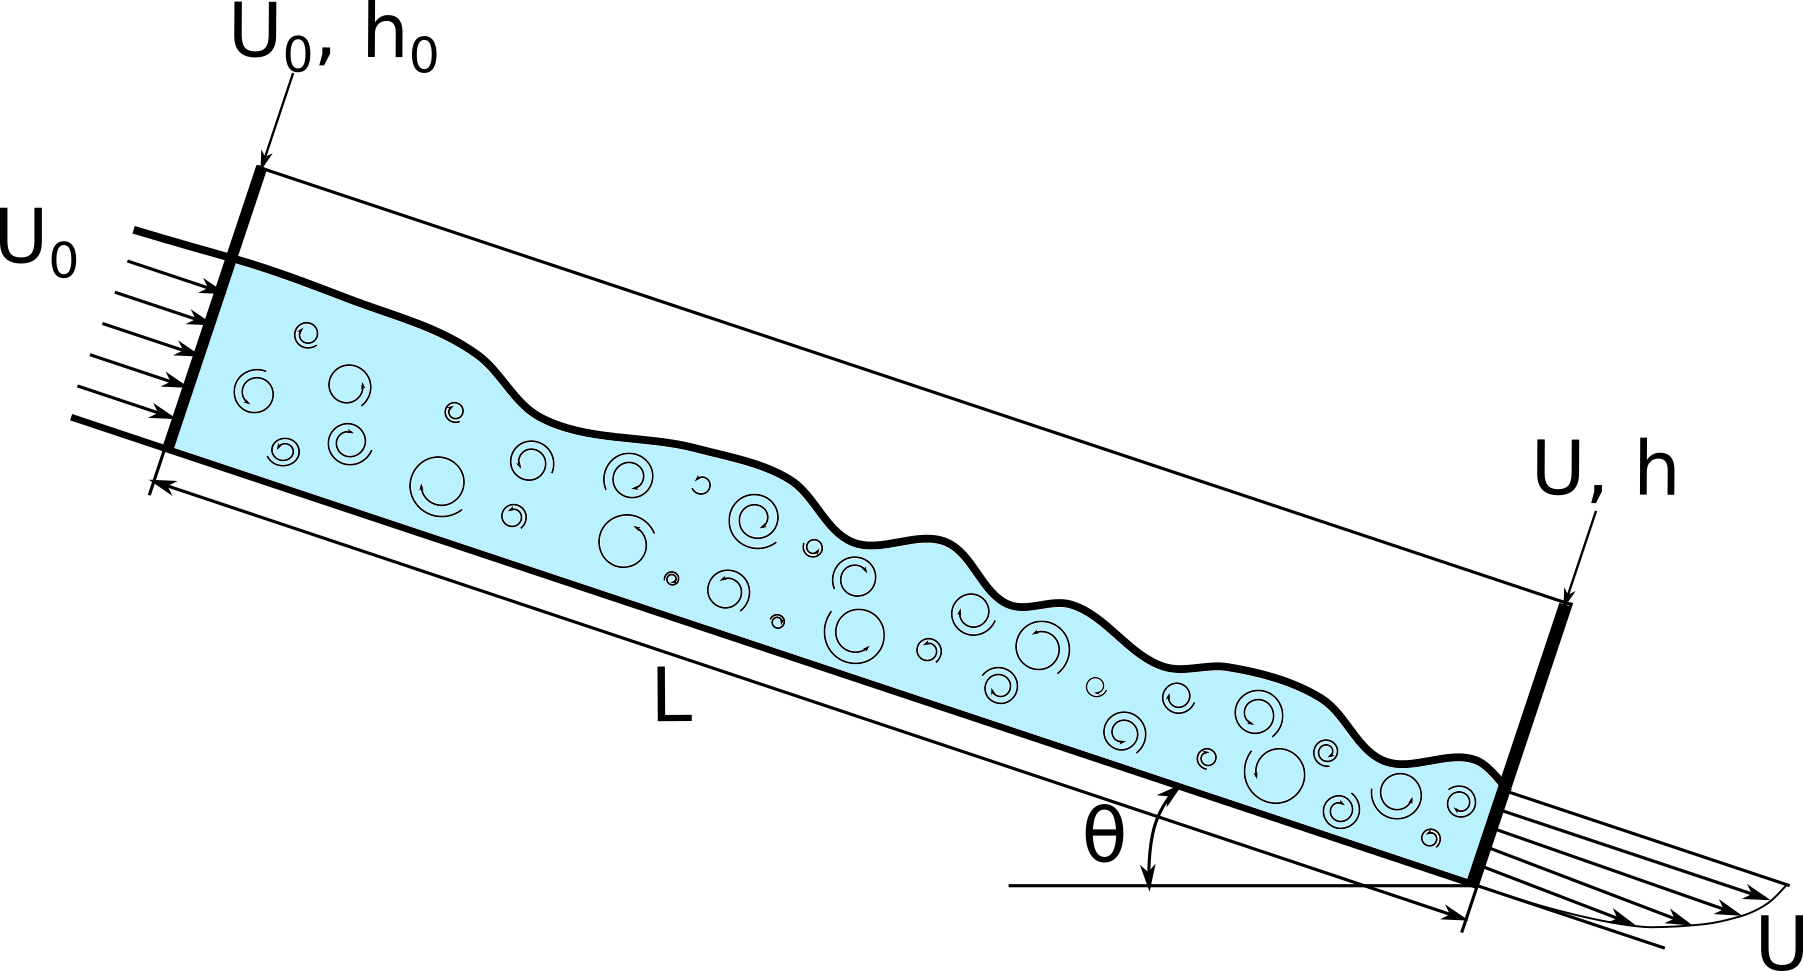
</div>

In the considered flow
\begin{equation}
    U_0 = 0.4\ \text{m}/\text{s},\ \ \ h_0 = 0.01\ \text{m},\ \ \ \theta = 25^\circ,\ \ \ L = 0.1\ \text{m}.
\end{equation}

Reynolds number of flow is 
\begin{equation}
    \text{Re} = U_0 h_0 / \nu_{eff},
\end{equation}

\begin{equation}
    \nu_{eff} = \frac{\tau_* + K (U_0/h_0)^n}{\rho (U_0 / h_0)}.
\end{equation}

Constants in calculation are set as follows:

\begin{equation}
    \nu_* = 10^7\ \text{m}^2/\text{s},\ \ \ \tau_* = 2 \cdot 10^{-3}\ \text{m}^2/\text{s}^2,\ \ \ K = 10^{-4}\ \text{m}^2/\text{s},\ \ \ n = 0.8,\ \ \ \rho = 100\ \text{kg}/\text{m}^3.
\end{equation}

So effective viscosity and Reynolds number are:

\begin{equation}
    \nu_{eff} = 10^{-6}\ \text{m}^2/\text{s},\ \ \ \text{Re} = 4000.
\end{equation}

The mesh cell linear size must be $dx = \frac{h_0}{\text{Re}^{3/4}} = 2 \cdot 10^{-5}$. Time step $dt = 5 \cdot 10^{-5}$.

Mesh size for computational domain size of 0.1x0.011x0.002 m$^3$ is $27.5 \cdot 10^7$.

[1] S. B. Pope. A more general effective-viscosity hypothesis.Journal of Fluid Mechanics,72(2):331–340, 1975.

## Current research

Above was global formulation for TBNN (Tensor Based Neural Network) with implemengtation into mathematical model. Now let's try to realize ML-turbulence model as a correction step for variables $\bar{\boldsymbol{u}}$, $\bar{\alpha}$, $\bar{p}$.

Will use tensors $\boldsymbol{T}^{(i)}$, invariants $\lambda_i$ and variables $\bar{\boldsymbol{u}}$, $\bar{p}$, $\bar{\alpha}$ as a features of NN (Neural Network). As a targets will be the differenses between DNS and RANS values for $\boldsymbol{u}$, $\alpha$ and $p$.

Let's start with importing libraries.

In [1]:
!python3 --version

Python 3.8.10


In [37]:
#!pip install git+https://github.com/tensorflow/docs
#!pip install -q -U keras-tuner
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
#!pip install pyyaml h5py


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
import subprocess as sp
import fileinput as fi
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.8.0


In [35]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Functions definitions

In [2]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype('float32'))
    timeStepsList = timeStepsList[index]
    return list(timeStepsList[1:-2])

In [3]:
def readTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0],
                      header=None,
                      skiprows=23, 
                      nrows=sz, 
                      dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', 
                   fileName[0]+'3', fileName[0]+'4', fileName[0]+'5', 
                   fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr = arr.astype('float32')
    return arr

In [4]:
def readSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], 
                      header=None, 
                      skiprows=23, 
                      nrows=sz, 
                      dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2',
                   fileName[0]+'3', fileName[0]+'4', fileName[0]+'5', 
                   fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr = arr.astype('float32')
    return arr[[fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'8']]

In [5]:
def readSkewSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], 
                      header=None, 
                      skiprows=23, 
                      nrows=sz, 
                      dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', 
                   fileName[0]+'3', fileName[0]+'4', fileName[0]+'5', 
                   fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr = arr.astype('float32')
    return arr[[fileName[0]+'1', fileName[0]+'2', fileName[0]+'5']]

In [6]:
def readVector(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], 
                      header=None, 
                      skiprows=23, 
                      nrows=sz, 
                      dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2']
    arr = arr.astype('float32')
    return arr

In [7]:
def readScalar(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], 
                      header=None, 
                      skiprows=23, 
                      nrows=sz, 
                      dtype=str)
    arr.columns = [fileName[0]]
    arr = arr.astype('float32')
    return arr

In [8]:
def prepareTarget(data):
    data['dU0'] = data['res/Uref0'] - data['res/U0']
    data['dU1'] = data['res/Uref1'] - data['res/U1']
    data['dU2'] = data['res/Uref2'] - data['res/U2']
    data['dAW'] = data['res/AWref'] - data['res/alpha.water']
    data['dp'] = data['res/p_rghref'] - data['res/p_rgh']

In [9]:
def prepareInit(fullData):
    data = fullData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
    data['dU0'] = fullData['dU0']# / fullData['res/Uref0']
    data['dU1'] = fullData['dU1']# / fullData['res/Uref1']
    data['dU2'] = fullData['dU2']# / fullData['res/Uref2']
    data['dAW'] = fullData['dAW']# / fullData['res/AWref']
    data['dp'] = fullData['dp']# / fullData['res/p_rghref']
    return data

In [10]:
def preparePrediction(dataPredicted, fullData):
    data = dataPredicted.copy()
    data['dU0'] = (fullData['dU0'] - dataPredicted['dU0'])# / fullData['res/Uref0']
    data['dU1'] = (fullData['dU1'] - dataPredicted['dU1'])# / fullData['res/Uref1']
    data['dU2'] = (fullData['dU2'] - dataPredicted['dU2'])# / fullData['res/Uref2']
    data['dAW'] = (fullData['dAW'] - dataPredicted['dAW'])# / fullData['res/AWref']
    data['dp'] = (fullData['dp'] - dataPredicted['dp'])# / fullData['res/p_rghref']
    return data

In [11]:
def formDataset(TSL, TSLlen, folder, FsScalars, FsVectors, FsTensors, FsSymmTensors, \
                FsSkewSymmTensors, size):
    data = pd.DataFrame()
    for time in TSL:
        #if TSLlen == 1:
        #    time = TSL
        kwargs = {'folder':folder, 'time':time, 'sz':size}
        scalars = FsScalars.apply(readScalar, axis=1, **kwargs)
        vectors = FsVectors.apply(readVector, axis=1, **kwargs)
        tensors = FsTensors.apply(readTensor, axis=1, **kwargs)
        symmTensors = FsSymmTensors.apply(readSymmTensor, axis=1, **kwargs)
        skewSymmTensors = FsSkewSymmTensors.apply(readSkewSymmTensor, axis=1, **kwargs)
        tmp = pd.concat(\
                        list(scalars[:])+\
                        list(vectors[:])+\
                        list(tensors[:])+\
                        list(symmTensors[:])+\
                        list(skewSymmTensors[:]), axis=1)
        data = data.append(tmp, ignore_index=True)
        prepareTarget(data)
        if TSLlen == 1:
            break
    return data

In [12]:
def writePrediction(arr, arrType, time, folder, fileName):
    sp.run('cp '+folder+time+'/patterns/'+fileName+'PatternBeginning '+folder+time+'/'+ \
           time+'/'+fileName, shell=True, check=True)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as f:
        f.write(str(len(arr))+'\n(\n')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('folderName', '"'+time+'"'), end='')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('fieldName', fileName), end='')
    if arrType == 'vector':
        arr = arr.astype(str)
        arr = '( '+arr.iloc[:,0]+' '+arr.iloc[:,1]+' '+arr.iloc[:,2]+' )'
    elif arrType == 'scalar':
        arr = arr.astype(str)
    arr.to_csv(folder+time+'/'+time+'/'+fileName, mode='a', index=False, header=False)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as\
        fout, fi.input(folder+time+'/'+'patterns/'+fileName+'PatternEnding') as fin:
            for line in fin:
                fout.write(line)

Below all features listed. alpha.water is $\bar{\alpha}$, 'alpha.water', 'U' and 'p_rgh' are initial values. Parameters from res/ folder are calculated without turbulence model using base interFoam solver. 'Uref', 'AWref' and 'p_rghref' are reference values calculated using DNS data.

# Data Preparation

In [13]:
MLturbRANSfolder = 'TIF'
KEturbRANSfolder = 'KEIF'
KWturbRANSfolder = 'KWIF'
deltaT = 1e-06
size = 300000
FsScalarsLabels = [\
    ['alpha.water'], ['res/alpha.water'], ['res/AWref'], ['p_rgh'], ['res/p_rgh'],\
    ['res/p_rghref'], ['res/I0'], ['res/I1'], ['res/I2'], ['res/I3'], ['res/I4'],\
    ['res/magGradP'], ['res/magGradAW'], ['res/inv1GradU'], ['res/inv2GradU']\
    ]
FsScalars = pd.DataFrame(FsScalarsLabels)
FsVectorLabels = [['U'], ['res/U'], ['res/Uref'], ['res/gradP'], ['res/gradAW']]
FsVectors = pd.DataFrame(FsVectorLabels)
FsTensorLabels = [['res/gradU']]
FsTensors = pd.DataFrame(FsTensorLabels)
FsSymmTensorsLabels = [\
    ['res/T0'], ['res/T1'], ['res/T2'], ['res/T3'], ['res/T4'], ['res/T5'], \
    ['res/T6'], ['res/T7'], ['res/T8'], ['res/T9']\
    ]
FsSymmTensors = pd.DataFrame(FsSymmTensorsLabels)
FsSkewSymmTensorsLabels = [['res/rotationRateTensor']]
FsSkewSymmTensors = pd.DataFrame(FsSkewSymmTensorsLabels)

In [14]:
target_labels = ['dU0', 'dU1', 'dU2', 'dAW', 'dp']
tensor_labels = [\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5',
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4',\
    'res/gradU5', 'res/gradU6', 'res/gradU7', 'res/gradU8']
grad_labels = [\
    'res/gradP0', 'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',\
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4', 'res/gradU5',\
    'res/gradU6', 'res/gradU7', 'res/gradU8']
vector_labels = ['U0', 'U1', 'U2', 'res/U0', 'res/U1', 'res/U2']
param_labels = ['alpha.water', 'p_rgh', 'res/p_rgh', 'res/alpha.water']
invar_labels = ['res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4',\
    'res/magGradP', 'res/magGradAW', 'res/inv1GradU', 'res/inv2GradU']
long_input_labels = invar_labels
short_input_labels = tensor_labels + grad_labels + vector_labels +\
                    param_labels
features_labels = long_input_labels + short_input_labels

In [32]:
# def load_data(time, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                         FsSymmTensors, FsSkewSymmTensors, size, 
#                           short_input_labels, long_input_labels, target_labels):
#     trainData = formDataset([time], 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                         FsSymmTensors, FsSkewSymmTensors, size)
#     print('data was loaded\n')
#     trainData.sample(frac=1)
#     train_target = trainData.loc[:, target_labels]
#     train_features_short = trainData.loc[:, short_input_labels]
#     train_features_long = trainData.loc[:, long_input_labels]
#     return ([train_features_long, train_features_short], train_target)

In [38]:
# def batch_generator(mode, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                         FsSymmTensors, FsSkewSymmTensors, size, 
#                        short_input_labels, long_input_labels, target_labels):
#     TSL = timeStepsList()
#     print("TSL\n")
#     print(TSL)
#     print("\n")
#     print("mode: ", mode, "\n")
#     if (mode == 'train'):
#         TSL = TSL[:2]
#     #elif (mode == 'validation'):
#     #    TSL = TSL[5]
#     elif (mode == 'test'):
#         TSL = TSL[-2:]
#     print(TSL, "\n")
    
#     idx = -1
#     while True: 
#         if idx < len(TSL):
#             idx += 1
#         else:
#             idx = 0
#         yield load_data(TSL[idx], MLturbRANSfolder, FsScalars, FsVectors, FsTensors,  
#                         FsSymmTensors, FsSkewSymmTensors, size, 
#                         short_input_labels, long_input_labels, target_labels)
#         print(idx)
    

In [39]:
#train_batch_generator = batch_generator('train', MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                        FsSymmTensors, FsSkewSymmTensors, size, 
#                       short_input_labels, long_input_labels, target_labels)
#validation_batch_generator = batch_generator('validation', MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                        FsSymmTensors, FsSkewSymmTensors, size, 
#                       short_input_labels, long_input_labels, target_labels)

In [15]:
%%time
TSL = timeStepsList()
TSL = TSL[:1]
trainData = formDataset(TSL, len(TSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
                        FsSymmTensors, FsSkewSymmTensors, size)
#valData = formDataset([TSL[5]], 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
#                        FsSymmTensors, FsSkewSymmTensors, size)
#testData = formDataset(testTSL, len(testTSL), MLturbRANSfolder, FsScalars, FsVectors, 
#                       FsTensors, FsSymmTensors, FsSkewSymmTensors, size)
#testCenterData = formDataset(testCenterTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, 
#                             FsTensors, FsSymmTensors, FsSkewSymmTensors, size)
#testLastData = formDataset(testLastTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors,\
#                           FsSymmTensors, FsSkewSymmTensors, size)

#testKEData = formDataset(testTSL, len(testTSL), KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                         ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKECenterData = formDataset(testCenterTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                               ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKELastData = formDataset(testLastTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                             ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)

#testKWData = formDataset(testTSL, len(testTSL), KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                         ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKWCenterData = formDataset(testCenterTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                               ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKWLastData = formDataset(testLastTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                             ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)

#trainData.describe().transpose()

CPU times: user 1min 13s, sys: 4.2 s, total: 1min 17s
Wall time: 1min 17s


In [16]:
train_target = trainData.loc[:, target_labels]
train_features_short = trainData.loc[:, short_input_labels]
train_features_long = trainData.loc[:, long_input_labels]
train_features = trainData.loc[:, features_labels]

#test_target = testData.loc[:, target_labels]
#test_features_short = testData.loc[:, short_input_labels]
#test_features_long = testData.loc[:, long_input_labels]
#test_features = testData.loc[:, features_labels]

# Preparation for training

In [42]:
# def compile_and_fit(model, name, train_batch_generator_ = train_batch_generator,                    
#                     steps_per_epoch_ = STEPS_PER_EPOCH, k = 1, version = "",
#                     optimizer=None, max_epochs=1000, callbacks=None):
    
#     saved_models_dir = "/home/nargiza/repo_2/tbnnTurbulenceTraining/" + \
#     "constantAngleSlopeDNS_U4e-1_A5_H1e-2_RANSsets/saved_model"
#     #weights_file = os.path.join(saved_models_dir, name + "_" + version + ".hdf5") 
#     model_dir = os.path.join(saved_models_dir, name + version)
#     if (not os.path.exists(model_dir)):
#         os.mkdir(model_dir)
#     filepath = os.path.join(model_dir, "{epoch:03d}-{loss:.4f}.h5")
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
#                                  monitor='loss',
#                                  save_best_only=True,
#                                  save_weights_only = True)

#     #model.save_weights(filepath.format(epoch=0))
    
#     if optimizer is None:
#         optimizer = get_optimizer()
#     model.compile(optimizer=optimizer,
#                   loss='mean_absolute_error',
#                   metrics=[tf.keras.metrics.MeanAbsoluteError(
#                       name='mean_absolute_error')])

#     model.summary()

#     history = model.fit(
#         train_batch_generator_,
#         steps_per_epoch = steps_per_epoch_ * k,
#         epochs = max_epochs,
#         verbose = 1,
#         callbacks = [checkpoint])
#     model.save(os.path.join(model_dir, name + "_model"))
#     return history

In [46]:
# def compile_and_fitTBNN(model, name, optimizer=None, max_epochs=1000, callbacks=None, k = 1):
#     if optimizer is None:
#         optimizer = get_optimizer()
    
#     model.compile(optimizer=optimizer,
#                   loss='mean_absolute_error',
#                   metrics=[tf.keras.metrics.MeanAbsoluteError(
#                       name='mean_absolute_error')])

#     model.summary()

#     history = model.fit(
#         [train_features_long, train_features_short],
#         train_target,
#         steps_per_epoch = STEPS_PER_EPOCH * k,
#         epochs=max_epochs,
#         validation_split=0.2,
#         verbose=1,
#         callbacks=callbacks)
#     return history

In [17]:
normalizer_tensors = tf.keras.layers.Normalization(axis=-1)
normalizer_tensors.adapt(train_features_short)
normalizer_no_tensors = tf.keras.layers.Normalization(axis=-1)
normalizer_no_tensors.adapt(train_features_long)
#normalizer_tensors = tf.keras.layers.Normalization(axis=-1, mean = 0, variance = 1)
#normalizer_no_tensors = tf.keras.layers.Normalization(axis=-1, mean = 0, variance = 1)

# Architecture

In [19]:
inputs_long_ = keras.Input(shape=(len(long_input_labels),),
                                name='Flow_parameters_input_layer')
inputs_short_ = keras.Input(shape=(len(short_input_labels),),
                             name='Tensor_input_layer')
norm_long = normalizer_no_tensors(inputs_long_)
norm_short = normalizer_tensors(inputs_short_)

denseLayer1 = layers.Dense(64,
                           name='First_hidden_layer')(norm_short)
denseLayer2 = layers.Dense(64,
                           name='Second_hidden_layer')(denseLayer1)
concat = layers.concatenate([denseLayer2, norm_long],
                            name='Parameters_concatenation')
outputs = layers.Dense(len(train_target.columns),
                       name='Last_hidden_layer')(concat)

# Model Training

In [20]:
%%time
TBNNModel_batch_train = keras.Model(
    inputs=[inputs_long_, inputs_short_],
    outputs=outputs,
)
name = "TBNNModel_batch_train"
version = "_1"
model = TBNNModel_batch_train
saved_models_dir = "/home/nargiza/repo_2/tbnnTurbulenceTraining/" + \
    "constantAngleSlopeDNS_U4e-1_A5_H1e-2_RANSsets/saved_model"
model_dir = os.path.join(saved_models_dir, name + version)
if (not os.path.exists(model_dir)):
    os.mkdir(model_dir)
filepath = os.path.join(model_dir, "{epoch:03d}-{val_loss:.4f}.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
                                 monitor='val_loss',
                                 save_best_only=True,
                                 save_weights_only = True)
batch_size = 5000
steps_per_epoch = len(trainData) // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=steps_per_epoch*10,
    decay_rate=1,
    staircase=False)


def get_optimizer(lr_schedule=lr_schedule):
    return tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)# lr_schedule)

optimizer = get_optimizer()
model.compile(optimizer=optimizer,
                 loss='mean_absolute_error',
                 metrics=[tf.keras.metrics.MeanAbsoluteError(
                 name='mean_absolute_error')])

model.summary()
TSL = timeStepsList()
TSL = TSL[:3]
batches_num = len(TSL)
epochs_num = 10
for i in range(epochs_num):
    real_i = epochs_num % batches_num
    trainData = formDataset([TSL[real_i]], 1, MLturbRANSfolder, FsScalars, FsVectors,\
                                FsTensors, FsSymmTensors, FsSkewSymmTensors, size)
    steps_per_epoch = len(trainData) // batch_size
    trainData.sample(frac=1)
    train_target = trainData.loc[:, target_labels]
    train_features_short = trainData.loc[:, short_input_labels]
    train_features_long = trainData.loc[:, long_input_labels]
        
    model.fit(
        [train_features_long, train_features_short],
        train_target,
        steps_per_epoch = steps_per_epoch,
        epochs = 2,
        validation_split = 0.2,
        verbose = 1,
        callbacks = [checkpoint],
        use_multiprocessing = True)
model.save(os.path.join(model_dir, name + "_model"))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tensor_input_layer (InputLayer  [(None, 97)]        0           []                               
 )                                                                                                
                                                                                                  
 normalization (Normalization)  (None, 97)           195         ['Tensor_input_layer[0][0]']     
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           6272        ['normalization[0][0]']          
                                                                                                  
 Flow_parameters_input_layer (I  [(None, 9)]         0           []                           

INFO:tensorflow:Assets written to: /home/nargiza/repo_2/tbnnTurbulenceTraining/constantAngleSlopeDNS_U4e-1_A5_H1e-2_RANSsets/saved_model/TBNNModel_batch_train_1/TBNNModel_batch_train_model/assets


INFO:tensorflow:Assets written to: /home/nargiza/repo_2/tbnnTurbulenceTraining/constantAngleSlopeDNS_U4e-1_A5_H1e-2_RANSsets/saved_model/TBNNModel_batch_train_1/TBNNModel_batch_train_model/assets


CPU times: user 13min 4s, sys: 35.1 s, total: 13min 39s
Wall time: 12min 41s


In [25]:
%%time
TSL = timeStepsList()
testTSL = TSL[-2:]
testData = formDataset(testTSL, len(testTSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, 
                        FsSymmTensors, FsSkewSymmTensors, size)

test_target = testData.loc[:, target_labels]
test_features_short = testData.loc[:, short_input_labels]
test_features_long = testData.loc[:, long_input_labels]


/usr/lib/python3/dist-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


CPU times: user 2min 23s, sys: 5.18 s, total: 2min 28s
Wall time: 2min 29s


In [31]:
all_models = {}
all_models[name + version] = model.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
pd.DataFrame(all_models).T

,0,1
TBNNModel_batch_train_1,0.066554,0.066554


In [38]:
loaded_model = keras.models.load_model(os.path.join(model_dir, name + "_model"))
loaded_model.compile(optimizer=optimizer,
                 loss='mean_absolute_error',
                 metrics=[tf.keras.metrics.MeanAbsoluteError(
                 name='mean_absolute_error')])
#TODO: load weights from the last modified file with weights ('cause last = best when we use
# save_best_only = True)
loaded_model.load_weights(os.path.join(model_dir,'001-0.0201.h5'))

In [39]:
all_models[name + version + '_loaded_from_best_epoch'] = loaded_model.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
pd.DataFrame(all_models).T

,0,1
TBNNModel_batch_train_1,0.066554,0.066554
TBNNModel_batch_train_1_loaded,0.067113,0.067113
TBNNModel_batch_train_1_loaded_from_best_epoch,0.067113,0.067113


In [40]:
model.save_weights(os.path.join(model_dir, 'last_epoch.h5'))

loaded_model = keras.models.load_model(os.path.join(model_dir, name + "_model"))
loaded_model.compile(optimizer=optimizer,
                 loss='mean_absolute_error',
                 metrics=[tf.keras.metrics.MeanAbsoluteError(
                 name='mean_absolute_error')])
loaded_model.load_weights(os.path.join(model_dir,'last_epoch.h5'))

In [41]:
all_models[name + version + '_loaded_from_last_epoch'] = loaded_model.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
pd.DataFrame(all_models).T
#so we save best weights during training, and we can also save the weights after all epochs
# .evaluate method uses weights from last epoch even if they are not the best?

,0,1
TBNNModel_batch_train_1,0.066554,0.066554
TBNNModel_batch_train_1_loaded,0.067113,0.067113
TBNNModel_batch_train_1_loaded_from_best_epoch,0.067113,0.067113
TBNNModel_batch_train_1_loaded_from_last_epoch,0.066554,0.066554


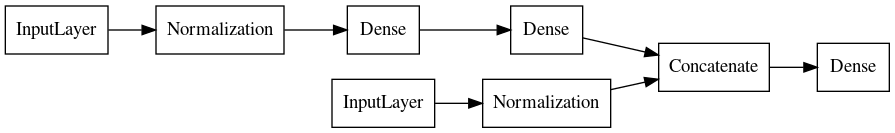

In [50]:
keras.utils.plot_model(TBNNModel_changed_branches, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')

## Model Training (old results, no batches)

In [54]:
histories = {}

In [42]:
%%time
histories['TBNNModel'] = compile_and_fitTBNN(
#histories['TBNNModel'] = compile_and_fit(
    TBNNModel,
    'TBNNModel',
#    [inputs_long, inputs_short],
#    train_target,
    max_epochs=50)#,
    #callbacks=[cp_callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Flow_parameters_input_layer (I  [(None, 30)]        0           []                               
 nputLayer)                                                                                       
                                                                                                  
 normalization_2 (Normalization  (None, 30)          61          ['Flow_parameters_input_layer[0][
 )                                                               0]']                             
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           1984        ['normalization_2[0][0]']        
                                                                                              

Epoch 34/50
120/120 [==============================] - 2s 15ms/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0126 - val_mean_absolute_error: 0.0126
Epoch 35/50
120/120 [==============================] - 2s 16ms/step - loss: 0.0234 - mean_absolute_error: 0.0234 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 36/50
120/120 [==============================] - 2s 16ms/step - loss: 0.0242 - mean_absolute_error: 0.0242 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 37/50
120/120 [==============================] - 2s 15ms/step - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 38/50
120/120 [==============================] - 2s 16ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 39/50
120/120 [==============================] - 2s 15ms/step - loss: 0.0262 - mean_absolute_error: 0.0262 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoc

In [51]:
%%time
#DATA:
#long_input_labels = invar_labels
#short_input_labels = tensor_labels + grad_labels + vector_labels + param_labels
histories['TBNNModel'] = compile_and_fitTBNN(
#histories['TBNNModel'] = compile_and_fit(
    TBNNModel,
    'TBNNModel',
#    [inputs_long, inputs_short],
#    train_target,
    max_epochs=100)#,
    #callbacks=[cp_callback])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Flow_parameters_input_layer (I  [(None, 9)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 normalization_2 (Normalization  (None, 9)           19          ['Flow_parameters_input_layer[0][
 )                                                               0]']                             
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           640         ['normalization_2[1][0]']        
                                                                                            

120/120 [==============================] - 7s 59ms/step - loss: 0.5030 - mean_absolute_error: 0.5030 - val_loss: 0.1764 - val_mean_absolute_error: 0.1764
Epoch 83/100
120/120 [==============================] - 7s 57ms/step - loss: 0.5023 - mean_absolute_error: 0.5023 - val_loss: 0.1759 - val_mean_absolute_error: 0.1759
Epoch 84/100
120/120 [==============================] - 7s 57ms/step - loss: 0.5014 - mean_absolute_error: 0.5014 - val_loss: 0.1758 - val_mean_absolute_error: 0.1758
Epoch 85/100
120/120 [==============================] - 7s 57ms/step - loss: 0.5007 - mean_absolute_error: 0.5007 - val_loss: 0.1756 - val_mean_absolute_error: 0.1756
Epoch 86/100
120/120 [==============================] - 7s 57ms/step - loss: 0.5000 - mean_absolute_error: 0.5000 - val_loss: 0.1748 - val_mean_absolute_error: 0.1748
Epoch 87/100
120/120 [==============================] - 7s 58ms/step - loss: 0.4992 - mean_absolute_error: 0.4992 - val_loss: 0.1751 - val_mean_absolute_error: 0.1751
Epoch 88/10

In [88]:
%%time
#DATA:
#long_input_labels = tensor_labels + grad_labels + vector_labels + param_labels
#short_input_labels = invar_labels

histories['TBNNModel_changed_branches'] = compile_and_fitTBNN(
#histories['TBNNModel'] = compile_and_fit(
    TBNNModel_changed_branches,
    'TBNNModel_changed_branches',
#    [inputs_long, inputs_short],
#    train_target,
    max_epochs=100)#,
    #callbacks=[cp_callback])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tensor_input_layer (InputLayer  [(None, 97)]        0           []                               
 )                                                                                                
                                                                                                  
 normalization_8 (Normalization  (None, 97)          195         ['Tensor_input_layer[0][0]']     
 )                                                                                                
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           6272        ['normalization_8[1][0]']        
                                                                                            

120/120 [==============================] - 5s 42ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 83/100
120/120 [==============================] - 5s 42ms/step - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 84/100
120/120 [==============================] - 5s 42ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 85/100
120/120 [==============================] - 5s 39ms/step - loss: 0.0281 - mean_absolute_error: 0.0281 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138
Epoch 86/100
120/120 [==============================] - 5s 44ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 87/100
120/120 [==============================] - 5s 41ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 88/10

In [30]:
%%time
#DATA:
#shuffled_data
#long_input_labels = tensor_labels + grad_labels + vector_labels + param_labels
#short_input_labels = invar_labels

TBNNModel_changed_branches_2 = keras.Model(
    inputs=[inputs_long, inputs_short],
    outputs=outputs,
)

histories['TBNNModel_changed_branches_2'] = compile_and_fitTBNN(
    TBNNModel_changed_branches_2,
    'TBNNModel_changed_branches_2',
    max_epochs=100)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tensor_input_layer (InputLayer  [(None, 97)]        0           []                               
 )                                                                                                
                                                                                                  
 normalization_1 (Normalization  (None, 97)          195         ['Tensor_input_layer[0][0]']     
 )                                                                                                
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           6272        ['normalization_1[0][0]']        
                                                                                            

120/120 [==============================] - 4s 35ms/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 83/100
120/120 [==============================] - 4s 37ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 84/100
120/120 [==============================] - 4s 35ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 85/100
120/120 [==============================] - 4s 36ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 86/100
120/120 [==============================] - 4s 36ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 87/100
120/120 [==============================] - 4s 36ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 88/10

In [66]:
%%time
#DATA:
#shuffled_data
#long_input_labels = tensor_labels + grad_labels + vector_labels + param_labels
#short_input_labels = invar_labels

TBNNModel_changed_branches_3 = keras.Model(
    inputs=[inputs_long_, inputs_short_],
    outputs=outputs,
)

histories['TBNNModel_changed_branches_3'] = compile_and_fit(
    TBNNModel_changed_branches_3,
    'TBNNModel_changed_branches_3',
    [train_features_long, train_features_short],
    train_target,
    k = 1,
    max_epochs=200)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tensor_input_layer (InputLayer  [(None, 97)]        0           []                               
 )                                                                                                
                                                                                                  
 normalization_4 (Normalization  (None, 97)          195         ['Tensor_input_layer[0][0]']     
 )                                                                                                
                                                                                                  
 First_hidden_layer (Dense)     (None, 64)           6272        ['normalization_4[3][0]']        
                                                                                           

120/120 [==============================] - 7s 56ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 83/200
120/120 [==============================] - 7s 55ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141
Epoch 84/200
120/120 [==============================] - 6s 54ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 85/200
120/120 [==============================] - 6s 54ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141
Epoch 86/200
120/120 [==============================] - 3857s 32s/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145
Epoch 87/200
120/120 [==============================] - 7s 56ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 88/

Epoch 131/200
120/120 [==============================] - 7s 55ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 132/200
120/120 [==============================] - 7s 55ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 133/200
120/120 [==============================] - 7s 58ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 134/200
120/120 [==============================] - 7s 62ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 135/200
120/120 [==============================] - 7s 58ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 136/200
120/120 [==============================] - 7s 62ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0175 - val_mean_absolute_error:

Epoch 180/200
120/120 [==============================] - 7s 58ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 181/200
120/120 [==============================] - 7s 60ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 182/200
120/120 [==============================] - 7s 56ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138
Epoch 183/200
120/120 [==============================] - 7s 57ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 184/200
120/120 [==============================] - 7s 55ms/step - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162
Epoch 185/200
120/120 [==============================] - 7s 56ms/step - loss: 0.0285 - mean_absolute_error: 0.0285 - val_loss: 0.0124 - val_mean_absolute_error:

In [34]:
#TBNNModel.save('saved_model/TBNNModel_shuffled_data')

INFO:tensorflow:Assets written to: saved_model/TBNNModel_shuffled_data/assets


INFO:tensorflow:Assets written to: saved_model/TBNNModel_shuffled_data/assets


In [ ]:
TBNNModel_prediction_prepared = preparePrediction(TBNNModel_prediction, testData)
writePrediction(TBNNModel_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testTSL, MLturbRANSfolder ,'dU')
writePrediction(TBNNModel_prediction_prepared[['dp']], 'scalar', testTSL, MLturbRANSfolder ,'dp')
writePrediction(TBNNModel_prediction_prepared[['dAW']], 'scalar', testTSL, MLturbRANSfolder ,'dAW')

In [33]:
full_dnn_models = {}

In [36]:
full_dnn_models['TBNNModel_shuffled_data'] = TBNNModel.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)

In [91]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel_shuffled_data,0.287408,0.287408
TBNNModel_shuffled_data_train_check,0.288300,0.288300
TBNNModel,0.424738,0.424738
TBNNModel_train_check,0.426027,0.426027
TBNNModel_changed_branches,0.040257,0.040257
TBNNModel_changed_branches_train_check,0.039990,0.039990


In [68]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel_changed_branches_2,0.033976,0.033976
TBNNModel_changed_branches_2_train_check,0.034008,0.034008
TBNNModel_changed_branches_3,0.027513,0.027513
TBNNModel_changed_branches_3_train_check,0.027574,0.027574


In [38]:
full_dnn_models['TBNNModel_shuffled_data_train_check'] = TBNNModel.evaluate(
    [train_features_long, train_features_short],
    train_target,
    verbose=0)

In [52]:
full_dnn_models['TBNNModel'] = TBNNModel.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
full_dnn_models['TBNNModel_train_check'] = TBNNModel.evaluate(
    [train_features_long, train_features_short],
    train_target,
    verbose=0)

In [90]:
full_dnn_models['TBNNModel_changed_branches'] = TBNNModel_changed_branches.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
full_dnn_models['TBNNModel_changed_branches_train_check'] = TBNNModel_changed_branches.evaluate(
    [train_features_long, train_features_short],
    train_target,
    verbose=0)

In [34]:
full_dnn_models['TBNNModel_changed_branches_2'] = TBNNModel_changed_branches_2.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
full_dnn_models['TBNNModel_changed_branches_2_train_check'] = TBNNModel_changed_branches_2.evaluate(
    [train_features_long, train_features_short],
    train_target,
    verbose=0)

In [67]:
full_dnn_models['TBNNModel_changed_branches_3'] = TBNNModel_changed_branches_3.evaluate(
    [test_features_long, test_features_short],
    test_target,
    verbose=0)
full_dnn_models['TBNNModel_changed_branches_3_train_check'] = TBNNModel_changed_branches_3.evaluate(
    [train_features_long, train_features_short],
    train_target,
    verbose=0)

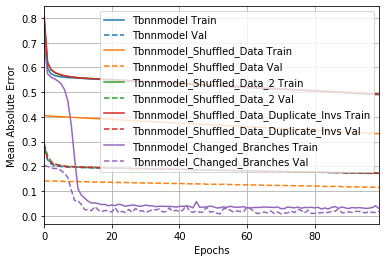

In [92]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
#plt.ylim([0., 0.5])

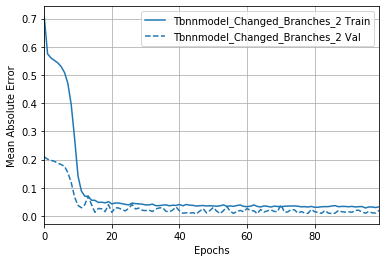

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
#plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
#!mkdir -p saved_model
#lnModel.save('lnModel.h5')
#lnModel = load_model('lnModel')

In [ ]:
#def TBNNModel_optimizer(hp):
#    hp_units1 = hp.Int('units1', min_value=8, max_value=80, step=8)
#    hp_units2 = hp.Int('units2', min_value=8, max_value=80, step=8)
#    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#    hp_activation = hp.Choice('activation', values=['elu', 'relu'])
#    
#    inputs_no_tensors = keras.Input(shape=(len(train_features_no_tensors.columns),),
#                                    name='Flow_parameters_input_layer')
#    inputs_tensors = keras.Input(shape=(len(train_features_tensors.columns),),
#                                 name='Tensor_input_layer')
#    norm_no_tensors = normalizer_no_tensors(inputs_no_tensors)
#    norm_tensors = normalizer_tensors(inputs_tensors)
#    denseLayer1 = layers.Dense(units=hp_units1,
#                               activation=hp_activation,
#                               name='First_hidden_layer')(norm_no_tensors)
#    denseLayer2 = layers.Dense(units=hp_units2,
#                               activation=hp_activation,
#                               name='Second_hidden_layer')(denseLayer1)
#    concat = layers.concatenate([denseLayer2, norm_tensors],
#                            name='Parameters_concatenation')
#    outputs = layers.Dense(len(train_labels.columns), name='Last_hidden_layer')(concat)
#    TBNNModel = keras.Model(
#        inputs=[inputs_no_tensors, inputs_tensors],
#        outputs=outputs,
#    )
#    
#    TBNNModel.compile(
#        optimizer=get_optimizer(),
#        #optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#        #optimizer=keras.optimizers.Adam(learning_rate=0.001),
#        loss='mean_absolute_error',
#        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error')])
#    return TBNNModel

In [ ]:
#tuner = kt.Hyperband(TBNNModel_optimizer,
#                     objective='val_loss',
#                     max_epochs=10,
#                     factor=3,
#                     directory='TBNNModelHpTuning',
#                     project_name='TBNNModelHpBest')

In [ ]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#%%time
#tuner.search(
#    [train_features_no_tensors, train_features_tensors],
#    train_labels,
#    epochs=50,
#    validation_split=0.2,
#    callbacks=[stop_early])

In [ ]:
# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#
#print(f"""
#The hyperparameter search is complete. The optimal number of units in the first densely-connected
#layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
#layer is {best_hps.get('units2')}, the optimal activation function
#is {best_hps.get('activation')}.
#""")

In [ ]:
#%%time
#TBNNModelHpBest = tuner.hypermodel.build(best_hps)
#histories['TBNNModelHpBest'] = TBNNModelHpBest.fit(
#    [train_features_no_tensors, train_features_tensors],
#    train_labels,
#    epochs=50,
#    validation_split=0.2)

In [ ]:
full_dnn_model_1 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [ ]:
%%time
histories['full_dnn_model_1'] = compile_and_fit(
    full_dnn_model_1,
    'full_dnn_model_1',
    max_epochs=50)

In [ ]:
full_dnn_models['full_dnn_model_1'] = full_dnn_model_1.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
full_dnn_model_2 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [ ]:
%%time
histories['full_dnn_model_2'] = compile_and_fit(
    full_dnn_model_2,
    'full_dnn_model_2',
    max_epochs=50)

In [ ]:
full_dnn_models['full_dnn_model_2'] = full_dnn_model_2.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
full_dnn_model_3 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [ ]:
%%time
histories['full_dnn_model_3'] = compile_and_fit(
    full_dnn_model_3,
    'full_dnn_model_3',
    max_epochs=50)

In [ ]:
full_dnn_models['full_dnn_model_3'] = full_dnn_model_3.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
full_dnn_model_4 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [ ]:
%%time
histories['full_dnn_model_4'] = compile_and_fit(
    full_dnn_model_4,
    'full_dnn_model_4',
    max_epochs=50)

In [ ]:
full_dnn_models['full_dnn_model_4'] = full_dnn_model_4.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
class LayerMultiplication(layers.Layer):
    def __init__(self, units=32):
        super(LayerMultiplication, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='w')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='b')

    def call(self, inputs):
        return tf.math.exp(tf.matmul(tf.math.log(tf.maximum(inputs, -2)+3), self.w) + self.b)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "w": self.w,
            "b": self.b,
        })
        return config

In [ ]:
normalizer_UPAW = tf.keras.layers.Normalization(axis=-1, mean=mean_UPAW, variance=var_UPAW)
normalizer_SR = tf.keras.layers.Normalization(axis=-1, mean=mean_SR, variance=var_SR)
normalizer_UPAWSR = tf.keras.layers.Normalization(axis=-1, mean=mean_UPAWSR, variance=var_UPAWSR)

In [ ]:
#lnModel
inputs_UPAWSR = keras.Input(shape=(len(train_features_UPAWSR.columns),))
norm_UPAWSR = normalizer_UPAWSR(inputs_UPAWSR)
multiplication = LayerMultiplication(len(train_features_UPAWSR.columns))(norm_UPAWSR)
linMembers = layers.concatenate([norm_UPAWSR, multiplication])
denseLayer1 = layers.Dense(64)(linMembers)
denseLayer2 = layers.Dense(64)(denseLayer1)
#denseLayer3 = layers.Dense(64)(denseLayer2)
outputs = layers.Dense(len(train_labels.columns))(denseLayer2)
lnModel = keras.Model(
    inputs=inputs_UPAWSR,
    outputs=outputs,
)

In [ ]:
train_features_UPAWSR.columns

In [ ]:
keras.utils.plot_model(lnModel, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')

In [ ]:
%%time
histories['lnModel'] = compile_and_fit(
    lnModel,
    'lnModel',
    train_features=train_features_UPAWSR,
    train_labels=train_labels,
    max_epochs=50)#,
    #callbacks=[cp_callback])

In [ ]:
full_dnn_models['lnModel'] = lnModel.evaluate(
    test_features_UPAWSR,
    test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [ ]:
pd.DataFrame(full_dnn_models).T

In [ ]:
#%%time
#full_dnn_model_3_prediction = pd.DataFrame(
#    data=full_dnn_model_3.predict(test_center_features),
#    columns=test_center_labels.columns)
#full_dnn_model_3_prediction

In [ ]:
#%%time
#TBNNModel_prediction = pd.DataFrame(
#    data=TBNNModel.predict(test_center_features),
#    columns=test_center_labels.columns)
#full_dnn_model_3_prediction

In [ ]:
#full_dnn_model_3_prediction_prepared = preparePrediction(full_dnn_model_3_prediction, testCenterData)
#writePrediction(full_dnn_model_3_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
#writePrediction(full_dnn_model_3_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
#writePrediction(full_dnn_model_3_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

#TBNNModel_prediction_prepared = preparePrediction(TBNNModel_prediction, testCenterData)
#writePrediction(TBNNModel_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
#writePrediction(TBNNModel_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
#writePrediction(TBNNModel_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

#testKECenterDataPrepared = prepareInit(testKECenterData)
#writePrediction(testKECenterData[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KEturbRANSfolder ,'dU')
#writePrediction(testKECenterData[['dp']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dp')
#writePrediction(testKECenterData[['dAW']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dAW')

#testKWCenterDataPrepared = prepareInit(testKWCenterData)
#writePrediction(testKWCenterData[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KWturbRANSfolder ,'dU')
#writePrediction(testKWCenterData[['dp']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dp')
#writePrediction(testKWCenterData[['dAW']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dAW')

#print(testCenterTSL)

In [ ]:
#testKECenterData.describe().T

In [ ]:
#testKWCenterData.describe().T

In [ ]:
#TBNNModel_prediction_prepared.describe().T